In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import cv2
from PIL import Image
import shutil
import glob
from zipfile import ZipFile
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import backend as K

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


In [8]:
image_filenames = os.listdir('/kaggle/input/whu-road-detection/1m_img_512')
# Set the source directories
image_dir = '/kaggle/input/whu-road-detection/1m_img_512'
mask_dir = '/kaggle/input/whu-road-detection/1m_lbl_512'

# Create destination directories
destination_dir = '/kaggle/working/whu-road-detection/train_data'
os.makedirs(os.path.join(destination_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'masks'), exist_ok=True)

# Randomly select 1000 image filenames
selected_filenames = random.sample(image_filenames, 6390)

# Function to move files to the new directory
def move_files(filenames, src_dir, dst_dir):
    for filename in filenames:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        shutil.copy(src_path, dst_path)

# Move selected images
move_files(selected_filenames, image_dir, os.path.join(destination_dir, 'images'))

# Move corresponding masks
move_files(selected_filenames, mask_dir, os.path.join(destination_dir, 'masks'))

print("Files moved successfully.")

Files moved successfully.


In [9]:
images = sorted(glob.glob('/kaggle/working/whu-road-detection/train_data/images/*.png'))
masks = sorted(glob.glob('/kaggle/working/whu-road-detection/train_data/masks/*.png'))
len(images),len(masks)

(6390, 6390)

In [10]:
image_filenames = os.listdir('/kaggle/working/whu-road-detection/train_data/images')
# Set the source directories
image_dir = '/kaggle/working/whu-road-detection/train_data/images'
mask_dir = '/kaggle/working/whu-road-detection/train_data/masks'

# Create destination directories
destination_dir = '/kaggle/working/whu-road-detection/val_data'
os.makedirs(os.path.join(destination_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'masks'), exist_ok=True)

# Randomly select 1000 image filenames
selected_filenames = random.sample(image_filenames, 1000)

# Function to move files to the new directory
def move_files(filenames, src_dir, dst_dir):
    for filename in filenames:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        shutil.move(src_path, dst_path)

# Move selected images
move_files(selected_filenames, image_dir, os.path.join(destination_dir, 'images'))

# Move corresponding masks
move_files(selected_filenames, mask_dir, os.path.join(destination_dir, 'masks'))

print("Files moved successfully.")

Files moved successfully.


In [11]:
images = sorted(glob.glob('/kaggle/working/whu-road-detection/train_data/images/*.png'))
masks = sorted(glob.glob('/kaggle/working/whu-road-detection/train_data/masks/*.png'))
len(images),len(masks)

(5390, 5390)

In [12]:
images = sorted(glob.glob('/kaggle/working/whu-road-detection/val_data/images/*.png'))
masks = sorted(glob.glob('/kaggle/working/whu-road-detection/val_data/masks/*.png'))
len(images),len(masks)

(1000, 1000)

In [13]:
# Define paths (you need to set these paths accordingly)
base_dir = '/kaggle/working/road_segmentation_results'
model_dir = os.path.join(base_dir, 'models')
log_dir = os.path.join(base_dir, 'logs')
plot_dir = os.path.join(base_dir, 'plots')
prediction_dir = os.path.join(base_dir, 'predictions')

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# Ensure directories exist
for dir_path in [model_dir, log_dir, plot_dir, prediction_dir]:
    os.makedirs(dir_path, exist_ok=True)

# DataGenerator class with data augmentation
# DataGenerator class with enhanced data augmentation
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=2, image_size=(512, 512), shuffle=True, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in indices]
        batch_mask_paths = [self.mask_paths[i] for i in indices]

        images, masks = self.__data_generation(batch_image_paths, batch_mask_paths)
        return images, masks

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_image_paths, batch_mask_paths):
        images = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, self.image_size)

            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.convert_image_dtype(mask, tf.float32)
            mask = tf.image.resize(mask, self.image_size)

            if self.augment:
                image, mask = self.__augment(image, mask)

            # Ensure binary mask
            mask = tf.where(mask > 0.5, 1.0, 0.0)

            images[i] = image.numpy()
            masks[i] = mask.numpy()

        return images, masks

    def __augment(self, image, mask):
        # Flip left-right
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
        
        # Flip up-down
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        
        # Random brightness (only for image)
        if tf.random.uniform(()) > 0.5:
            image = tf.image.random_brightness(image, max_delta=0.1)
        
        # Random contrast (only for image)
        if tf.random.uniform(()) > 0.5:
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        
        # Random saturation (only for image)
        if tf.random.uniform(()) > 0.5:
            image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
        
        # Random hue (only for image)
        if tf.random.uniform(()) > 0.5:
            image = tf.image.random_hue(image, max_delta=0.1)
        
        # Ensure the image values are still in [0, 1]
        image = tf.clip_by_value(image, 0, 1)
        
        return image, mask


# Define the paths
train_image_dir = '/kaggle/working/whu-road-detection/train_data/images'
train_mask_dir = '/kaggle/working/whu-road-detection/train_data/masks'
val_image_dir = '/kaggle/working/whu-road-detection/val_data/images'
val_mask_dir = '/kaggle/working/whu-road-detection/val_data/masks'

# Function to get the paths of images and masks
def get_image_mask_paths(image_dir, mask_dir):
    image_paths = []
    mask_paths = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.png'):
                image_paths.append(os.path.join(root, file))
                mask_paths.append(os.path.join(mask_dir, file))
    return image_paths, mask_paths

# Get the training and validation paths
train_image_paths, train_mask_paths = get_image_mask_paths(train_image_dir, train_mask_dir)
val_image_paths, val_mask_paths = get_image_mask_paths(val_image_dir, val_mask_dir)

# Create the DataGenerator instances
train_generator = DataGenerator(train_image_paths, train_mask_paths, batch_size=2, image_size=(512, 512), shuffle=True, augment=True)
val_generator = DataGenerator(val_image_paths, val_mask_paths, batch_size=2, image_size=(512, 512), shuffle=False, augment=False)


In [ ]:
def unet(input_shape=(512, 512, 3), output_channels=1):
    inputs = Input(input_shape)

    def encoder_block(x, filters, kernel_size=3, dropout=0.0):
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if dropout > 0:
            x = Dropout(dropout)(x)
        return x

    # Encoder path with additional layers
    e1 = encoder_block(inputs, 64)
    p1 = MaxPooling2D(pool_size=(2, 2))(e1)

    e2 = encoder_block(p1, 128)
    p2 = MaxPooling2D(pool_size=(2, 2))(e2)

    e3 = encoder_block(p2, 256, dropout=0.2)
    p3 = MaxPooling2D(pool_size=(2, 2))(e3)

    e4 = encoder_block(p3, 512, dropout=0.2)
    p4 = MaxPooling2D(pool_size=(2, 2))(e4)

    e5 = encoder_block(p4, 1024, dropout=0.3)
    p5 = MaxPooling2D(pool_size=(2, 2))(e5)

    # Bridge
    b = encoder_block(p5, 2048, dropout=0.4)

    def decoder_block(x, skip_connection, filters, kernel_size=3, dropout=0.0):
        x = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(x)
        x = Concatenate()([x, skip_connection])
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if dropout > 0:
            x = Dropout(dropout)(x)
        return x

    # Decoder path with additional layers
    d5 = decoder_block(b, e5, 1024, dropout=0.3)
    d4 = decoder_block(d5, e4, 512, dropout=0.2)
    d3 = decoder_block(d4, e3, 256, dropout=0.2)
    d2 = decoder_block(d3, e2, 128)
    d1 = decoder_block(d2, e1, 64)

    # Output
    outputs = Conv2D(output_channels, 1, activation='sigmoid', dtype='float32')(d1)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Usage
model = unet(input_shape=(512, 512, 3), output_channels=1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

In [16]:
from tensorflow.keras import backend as K
# Custom metrics with division-by-zero checks
def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

def jacard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return  jacard_coef_loss(y_true, y_pred)


In [17]:
# Compile the model with a lower initial learning rate
initial_learning_rate = 0.001
weight_decay = 1e-4
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate,weight_decay=weight_decay),
              loss=combined_loss,
              metrics=[precision, recall, f1_score, iou])

# Define callbacks
best_model_checkpoint = ModelCheckpoint(os.path.join(model_dir, 'model_best.keras'), 
                                        save_best_only=True, 
                                        monitor='val_loss', 
                                        mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
csv_logger = CSVLogger(os.path.join(log_dir, 'training_log.csv'))

# Custom callback for visualizing validation predictions
# Custom callback for visualizing validation predictions
class ValidationVisualization(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, output_dir, num_images=10):
        self.val_generator = val_generator
        self.output_dir = output_dir
        self.num_images = num_images
        os.makedirs(self.output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        val_data = next(iter(self.val_generator))
        val_images, val_masks = val_data[0], val_data[1]
        predictions = self.model.predict(val_images)

        # Binarize the predictions
        binary_predictions = (predictions > 0.5).astype(np.uint8)

        # Adjust number of images to visualize if batch size is smaller
        num_images = min(self.num_images, val_images.shape[0])

        fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
        for i in range(num_images):
            axes[i, 0].imshow(val_images[i])
            axes[i, 0].set_title("Input Image")
            axes[i, 1].imshow(val_masks[i].squeeze(), cmap='gray')
            axes[i, 1].set_title("True Mask")
            axes[i, 2].imshow(binary_predictions[i].squeeze(), cmap='gray')
            axes[i, 2].set_title("Predicted Mask")
        plt.savefig(os.path.join(self.output_dir, f'epoch_{epoch:02d}.png'))
        plt.show()  # Add this line to plot the images
        plt.close()


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-17 13:40:55.693027: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.96943, expected 4.13831
2024-07-17 13:40:55.693085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.82185, expected 5.99072
2024-07-17 13:40:55.693099: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.62315, expected 5.79201
2024-07-17 13:40:55.693116: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.80174, expected 5.97062
2024-07-17 13:40:55.693128: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step96ms/step - f1_score: 0.2220 - iou: 0.1384 - loss: -0.1384 - precision: 0.1792 - recall: 0.445


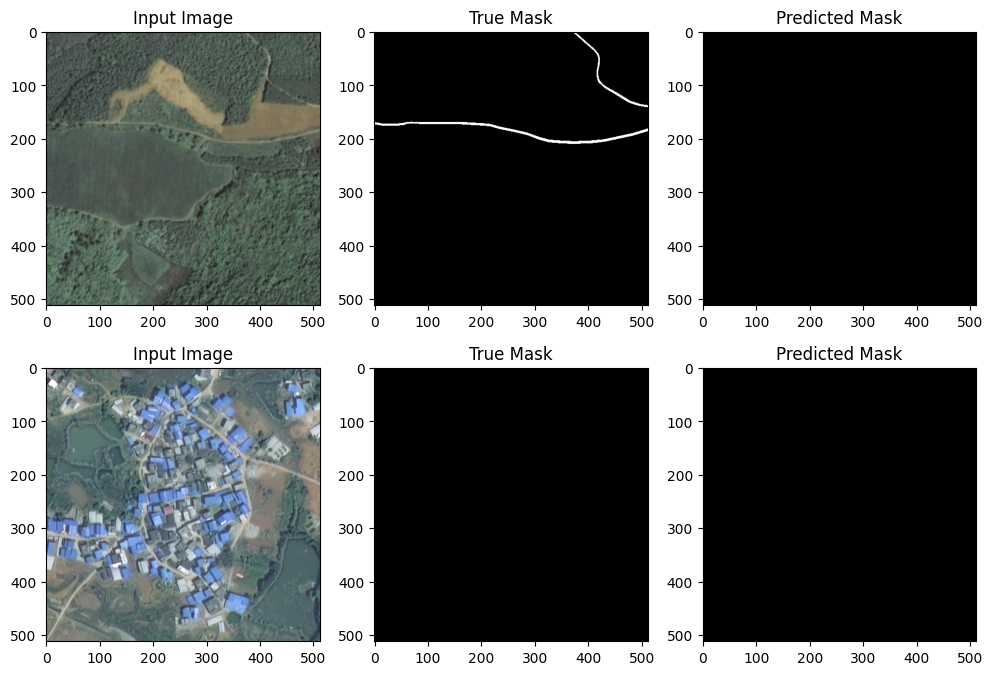

2695/2695 ━━━━━━━━━━━━━━━━━━━━ 930s 320ms/step - f1_score: 0.2220 - iou: 0.1384 - loss: -0.1384 - precision: 0.1792 - recall: 0.4459 - val_f1_score: 0.0639 - val_iou: 0.0400 - val_loss: -0.0475 - val_precision: 0.2017 - val_recall: 0.0451 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepms/step - f1_score: 0.3528 - iou: 0.2451 - loss: -0.2451 - precision: 0.3366 - recall: 0.469


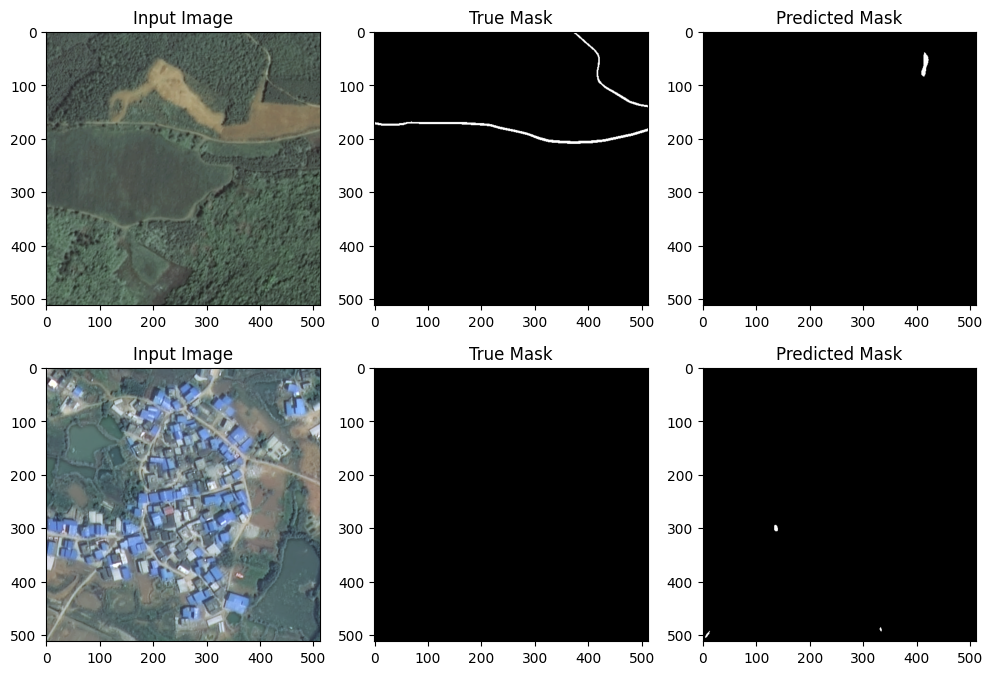

2695/2695 ━━━━━━━━━━━━━━━━━━━━ 857s 318ms/step - f1_score: 0.3528 - iou: 0.2451 - loss: -0.2451 - precision: 0.3366 - recall: 0.4697 - val_f1_score: 0.3255 - val_iou: 0.2185 - val_loss: -0.2222 - val_precision: 0.3201 - val_recall: 0.4502 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepms/step - f1_score: 0.4147 - iou: 0.3002 - loss: -0.3003 - precision: 0.4076 - recall: 0.533
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepms/step - f1_score: 0.4588 - iou: 0.3381 - loss: -0.3381 - precision: 0.4535 - recall: 0.555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepms/step - f1_score: 0.4836 - iou: 0.3587 - loss: -0.3587 - precision: 0.4869 - recall: 0.560
Epoch 6/100
1112/2695 ━━━━━━━━━━━━━━━━━━━━ 7:49 297ms/step - f1_score: 0.5126 - iou: 0.3843 - loss: -0.3844 - precision: 0.5140 - recall: 0.5839

In [ ]:
with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=val_generator,
        callbacks=[best_model_checkpoint, early_stopping, reduce_lr, csv_logger, ValidationVisualization(val_generator, prediction_dir)]
    )


In [ ]:
!zip -r file.zip /kaggle/working/road_segmentation_results
from IPython.display import FileLink
FileLink(r'file.zip')